# Function for Cluster Plot w/ Basic Linear Regression
## Example Parameter: Avg Leaf Nitrogen Concentration (LNC) vs Leaf Carbon Nitrogen Ratio (LCN)
#### Author: Heather Childers & Sofia Ingersoll 
##### Date: 2024-02-18

##### Loading environment settings

In [3]:
# moved the libraries that were here into utils.py because they're essential
# xarray is required to run the utils import line
import xarray as xr

In [21]:
# import libraries & data pre-processing functions from utils.py
from utils import *

##### Request additional processing power from server

In [5]:
# Request an additional 10 cores of power for processing from the server
client = get_cluster("UCSB0021", cores = 10)

/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36503 instead
  warnings.warn(


In [6]:
# apply peer2peer network communication across multiple devices
client.cluster

PBSCluster(fcbd2b5a, 'tcp://128.117.208.103:44737', workers=10, threads=10, memory=93.10 GiB)

### By loading utils,

A dummy data array `da` was loaded into our local environment. For the time being, we will be working with this pre-processed data set. The data variable of interest is:
LNC: leaf nitrogen content. 

In [22]:
# da is not currently being read in from the utils library, but ds is.
# how do we need to adjust how our utils.py is structured to store the processed data array for dummy data ?
da

NameError: name 'da' is not defined

In [17]:
ds

<xarray.Dataset>
Dimensions:                            (levgrnd: 25, levsoi: 20, levlak: 10,
                                        levdcmp: 25, time: 120,
                                        hist_interval: 2, lon: 144, lat: 96,
                                        gridcell: 400, landunit: 1148,
                                        column: 2599, pft: 4387, cft: 2,
                                        ltype: 9, nvegwcs: 4)
Coordinates:
  * levgrnd                            (levgrnd) float32 0.01 0.04 ... 42.0
  * levsoi                             (levsoi) float32 0.01 0.04 ... 6.94 8.03
  * levlak                             (levlak) float32 0.05 0.6 ... 34.33 44.78
  * levdcmp                            (levdcmp) float32 0.01 0.04 ... 42.0
  * time                               (time) object 2005-02-01 00:00:00 ... ...
  * lon                                (lon) float32 0.0 2.5 5.0 ... 355.0 357.5
  * lat                                (lat) float32 -90.0 -88.11 ... 88.11 90.0
Dimensions without coordinates: hist_interval, gridcell, landunit, column, pft,
                                cft, ltype, nvegwcs
Data variables: (12/497)
    mcdate                             (time) int32 ...
    mcsec                              (time) int32 ...
    mdcur                              (time) int32 ...
    mscur                              (time) int32 ...
    nstep                              (time) int32 ...
    time_bounds                        (time, hist_interval) object ...
    ...                                 ...
    XSMRPOOL                           (time, gridcell) float32 ...
    XSMRPOOL_RECOVER                   (time, gridcell) float32 ...
    ZBOT                               (time, gridcell) float32 ...
    ZWT                                (time, gridcell) float32 ...
    ZWT_CH4_UNSAT                      (time, gridcell) float32 ...
    ZWT_PERCH                          (time, gridcell) float32 ...
Attributes: (12/40)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 09/06/23 02:33:14
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    ...                                        ...
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./PPEn11_CTL2010_OAAT0000.clm2...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

### Leaf Carbon : Nitrogen Data

In [24]:
# Leaf CN data for plotting
df = pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt',index_col=0)
params = xr.Dataset(df)

## Loading a Cluster of 500 files
The data files are located in `/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/`

The 2005-2010 monthly output files have the form:
`PPEn11_transient_LHC0001.clm2.h0.2005-02-01-00000.nc`

We're interested in files spanning from:
`LHC0001 to LHC0500`

In [ ]:
# Open multiple files as a single dataset
# working on getting env resolved with glob addition
file_cluster = sorted(glob.glob('/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC*[0001-501].*'))

cluster_ds =xr.open_mfdataset(file_cluster,
                              combine = 'nested',
                              parallel = True,
                              concat_dim = "ens")

### Down sampled 2 file approach

In [ ]:
# Set filepath
#filepath = '/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/'

In [10]:
#members = ["LHC" + str(i).zfill(4) for i in range(1,501)]
#members

In [7]:
#Open multiple files as a single dataset
ds_mf =xr.open_mfdataset(['/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC0001.clm2.h0.2005-02-01-00000.nc', 
                          '/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC0002.clm2.h0.2005-02-01-00000.nc'], 
                         combine='nested', parallel=True, concat_dim = "ens")

In [15]:
ds_mf.time

<xarray.DataArray 'time' (time: 60)>
array([cftime.DatetimeNoLeap(2005, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2005, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2005, 4, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2005, 5, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2005, 6, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2005, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2005, 8, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2005, 9, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2005, 10, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2005, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2005, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 4, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 5, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 6, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 8, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 9, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 10, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2007, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2007, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2007, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2007, 4, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2007, 5, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2007, 6, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2007, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2007, 8, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2007, 9, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2007, 10, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2007, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2007, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 4, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 5, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 6, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 8, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 9, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 10, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2009, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2009, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2009, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2009, 4, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2009, 5, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2009, 6, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(

In [20]:
ds.time.max()

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(2010, 1, 1, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)

In [10]:
file2 = '/glade/campaign/cgd/tss/projects/PPE/helpers/sparsegrid_landarea.nc'
ds2 = xr.open_dataset(file2)
landarea = ds2['landarea']
weighted_avg_area = ds_mf['TSA'].weighted(landarea).mean(dim = 'gridcell').mean(dim = 'time')
weighted_avg_area.values

array([286.94476799, 287.01596784])

#### Single file visualization of LNC

In [10]:
# these are commented out because the utils library provides the same information in line 2
#file = "/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC0001.clm2.h0.2005-02-01-00000.nc"
#ds = xr.open_dataset(file)

In [7]:
lnc = ds['LNC']
lnc_timeavg = lnc.mean(dim = 'time')

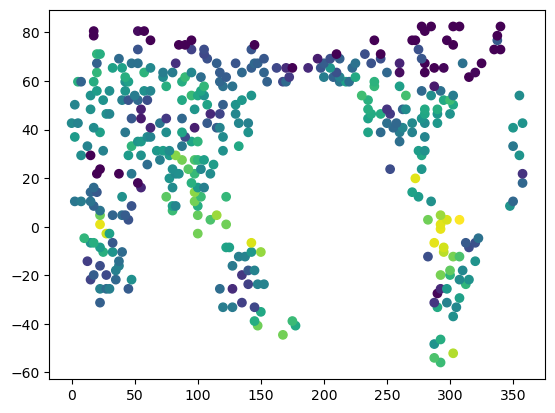

In [10]:
plt.scatter(ds.grid1d_lon,
            ds.grid1d_lat,
            c=lnc_timeavg)

In [23]:
#lnc_avg = lnc_timeavg.mean(dim = 'lat')